# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Payam Taebi

*SID:* 400104867

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
!pip install torch torchvision
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install requests
!pip install tqdm
!pip install scikit-learn
!pip install torchsummary

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from torchvision import transforms
from tqdm import tqdm
import tqdm
from time import time
from tqdm import tqdm
from datetime import datetime
import copy
from sklearn.manifold import TSNE
from torch.utils.data import ConcatDataset
from torchsummary import summary
from torchvision.datasets import CIFAR10
import random

## Device

Set device to work with (GPU or CPU)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #vase generalize
    transforms.RandomCrop(32, padding=4), #pad kardim ke gooshe ha ham beioofte
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)  # CIFAR-10 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:15<00:00, 11214060.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
sample_train = train_dataset[0][0] ## [i] mige ye tupe az ye tensor ke aks mast va [1] mishe addadi az 1 ta 10 ke class marboot hast
print("Shape of the first sample in train dataset:", sample_train.shape)

sample_val = val_dataset[0][0]
print("Shape of the first sample in validation dataset:", sample_val.shape)

sample_test = test_dataset[0][0]
print("Shape of the first sample in test dataset:", sample_test.shape)

for batch in train_loader:
    data, labels = batch
    print("Shape of data batch in train loader:", data.shape)
    print("Shape of labels batch in train loader:", labels.shape)
    break

for batch in val_loader:
    data, labels = batch
    print("Shape of data batch in validation loader:", data.shape)
    print("Shape of labels batch in validation loader:", labels.shape)
    break

for batch in test_loader:
    data, labels = batch
    print("Shape of data batch in test loader:", data.shape)
    print("Shape of labels batch in test loader:", labels.shape)
    break


Shape of the first sample in train dataset: torch.Size([3, 32, 32])
Shape of the first sample in validation dataset: torch.Size([3, 32, 32])
Shape of the first sample in test dataset: torch.Size([3, 32, 32])
Shape of data batch in train loader: torch.Size([64, 3, 32, 32])
Shape of labels batch in train loader: torch.Size([64])
Shape of data batch in validation loader: torch.Size([64, 3, 32, 32])
Shape of labels batch in validation loader: torch.Size([64])
Shape of data batch in test loader: torch.Size([64, 3, 32, 32])
Shape of labels batch in test loader: torch.Size([64])


In [7]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        #x - mu / sigma--> s * sigma + mu
        return tensor

norminv = UnNormalize(means, stds)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

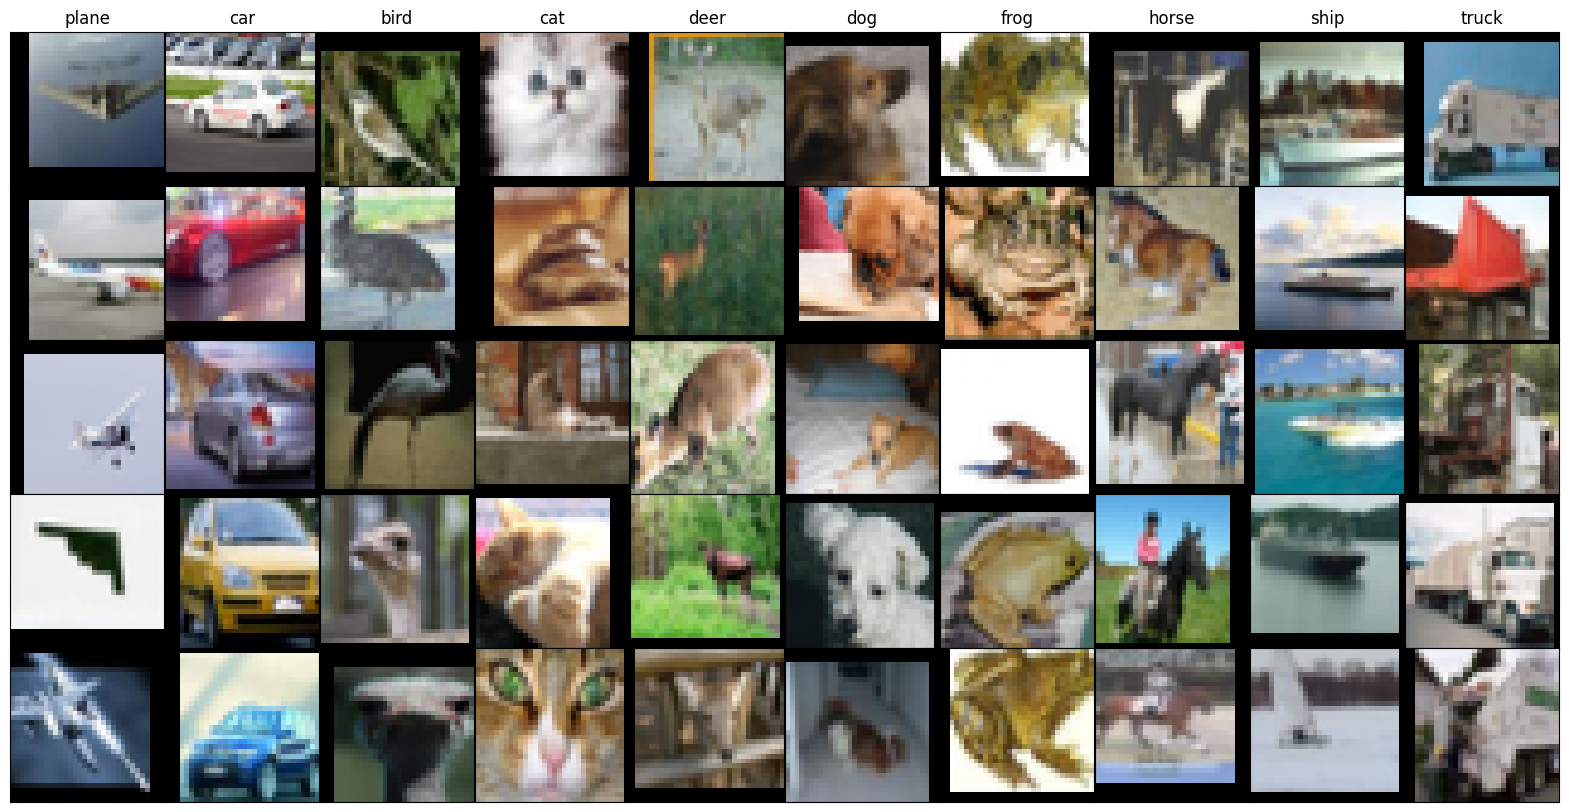

In [8]:
class_cnt = np.zeros(10)  #10 classes in CIFAR-10
class_images = [[] for _ in range(10)]
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_images[label.item()].append(img)
        class_cnt[label.item()] += 1
    if (class_cnt >= 5).all():
        break

fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for class_idx in range(10):
    for i in range(5):
        unnormalized_img = norminv(class_images[class_idx][i])
        unnormalized_img = np.clip(unnormalized_img.permute(1, 2, 0), 0, 1)  ## SOT
        axs[i, class_idx].imshow(unnormalized_img)
        axs[i, class_idx].get_xaxis().set_visible(False)
        axs[i, class_idx].get_yaxis().set_visible(False)
    axs[0, class_idx].set_title(f'{classes[class_idx]}')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

"""    def extract_features(self, x):
        features = []
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        features.append(out)
        out = self.layer1(out)
        features.append(out)
        out = self.layer2(out)
        features.append(out)
        out = self.layer3(out)
        features.append(out)
        out = self.layer4(out)
        features.append(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        features.append(out)
        return features"""


def ResNet18():
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Model moved to device: {device}")
    model = model.to(device)
    return model



## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [10]:
model = ResNet18()


summary(model, (3, 32, 32))

Model moved to device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      Batch

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [12]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0.0
    correct = 0.0
    total = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / len(dataloader), 'accuracy': 100 * correct / total})
    scheduler.step()

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    correct = 0.0
    total = 0
    pbar = tqdm(dataloader, desc="Validation" if not test_mode else "Testing", leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / len(dataloader), 'accuracy': 100 * correct / total})
    return correct / total, running_loss / len(dataloader)


In [13]:
# Train and validate the model
epochs = 40
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print(f'[Epoch {epoch + 1:2d}] [{datetime.now().strftime("%H:%M:%S")}]', end=' ' * 3)
    print(f'LR: {scheduler.get_last_lr()[0]:.6f}', end=' ' * 3)
    train_epoch(model, criterion, optimizer, scheduler, train_loader)
    train_acc, train_loss = eval_epoch(model, criterion, train_loader)
    valid_acc, valid_loss = eval_epoch(model, criterion, val_loader)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'Train Loss: {train_loss:.4f}   Train Accuracy: {train_acc:.2f}', end=' ' * 3)
    print(f'Validation Loss: {valid_loss:.4f}   Validation Accuracy: {valid_acc:.2f}')


print('Training complete.')


[Epoch  1] [20:01:18]   LR: 0.010000   

Train Loss: 1.3146   Train Accuracy: 0.53   Validation Loss: 1.3543   Validation Accuracy: 0.52
[Epoch  2] [20:01:57]   LR: 0.010000   

Train Loss: 1.0125   Train Accuracy: 0.64   Validation Loss: 1.0658   Validation Accuracy: 0.63
[Epoch  3] [20:02:36]   LR: 0.010000   

Train Loss: 0.7805   Train Accuracy: 0.73   Validation Loss: 0.8253   Validation Accuracy: 0.72
[Epoch  4] [20:03:14]   LR: 0.010000   

Train Loss: 0.5974   Train Accuracy: 0.79   Validation Loss: 0.6766   Validation Accuracy: 0.76
[Epoch  5] [20:03:53]   LR: 0.010000   

Train Loss: 0.5568   Train Accuracy: 0.81   Validation Loss: 0.6305   Validation Accuracy: 0.79
[Epoch  6] [20:04:31]   LR: 0.010000   

Train Loss: 0.5024   Train Accuracy: 0.83   Validation Loss: 0.5937   Validation Accuracy: 0.80
[Epoch  7] [20:05:09]   LR: 0.010000   

Train Loss: 0.4309   Train Accuracy: 0.85   Validation Loss: 0.5342   Validation Accuracy: 0.82
[Epoch  8] [20:05:48]   LR: 0.010000   

Train Loss: 0.3598   Train Accuracy: 0.88   Validation Loss: 0.4609   Validation Accuracy: 0.84
[Epoch  9] [20:06:26]   LR: 0.010000   

Train Loss: 0.5383   Train Accuracy: 0.82   Validation Loss: 0.6617   Validation Accuracy: 0.79
[Epoch 10] [20:07:04]   LR: 0.010000   

Train Loss: 0.3608   Train Accuracy: 0.87   Validation Loss: 0.4921   Validation Accuracy: 0.84
[Epoch 11] [20:07:43]   LR: 0.010000   

Train Loss: 0.3101   Train Accuracy: 0.89   Validation Loss: 0.4636   Validation Accuracy: 0.84
[Epoch 12] [20:08:21]   LR: 0.010000   

Train Loss: 0.3037   Train Accuracy: 0.89   Validation Loss: 0.4393   Validation Accuracy: 0.85
[Epoch 13] [20:08:59]   LR: 0.010000   

Train Loss: 0.2655   Train Accuracy: 0.91   Validation Loss: 0.4174   Validation Accuracy: 0.86
[Epoch 14] [20:09:38]   LR: 0.010000   

Train Loss: 0.2579   Train Accuracy: 0.91   Validation Loss: 0.4216   Validation Accuracy: 0.86
[Epoch 15] [20:10:16]   LR: 0.010000   

Train Loss: 0.2281   Train Accuracy: 0.92   Validation Loss: 0.4096   Validation Accuracy: 0.86
[Epoch 16] [20:10:55]   LR: 0.010000   

Train Loss: 0.2100   Train Accuracy: 0.93   Validation Loss: 0.3986   Validation Accuracy: 0.87
[Epoch 17] [20:11:33]   LR: 0.010000   

Train Loss: 0.2473   Train Accuracy: 0.91   Validation Loss: 0.4474   Validation Accuracy: 0.86
[Epoch 18] [20:12:12]   LR: 0.010000   

Train Loss: 0.1799   Train Accuracy: 0.94   Validation Loss: 0.3961   Validation Accuracy: 0.87
[Epoch 19] [20:12:50]   LR: 0.010000   

Train Loss: 0.1664   Train Accuracy: 0.94   Validation Loss: 0.3665   Validation Accuracy: 0.88
[Epoch 20] [20:13:29]   LR: 0.010000   

Train Loss: 0.1468   Train Accuracy: 0.95   Validation Loss: 0.3605   Validation Accuracy: 0.88
[Epoch 21] [20:14:08]   LR: 0.001000   

Train Loss: 0.0838   Train Accuracy: 0.97   Validation Loss: 0.3005   Validation Accuracy: 0.90
[Epoch 22] [20:14:47]   LR: 0.001000   

Train Loss: 0.0735   Train Accuracy: 0.98   Validation Loss: 0.2904   Validation Accuracy: 0.91
[Epoch 23] [20:15:26]   LR: 0.001000   

Train Loss: 0.0668   Train Accuracy: 0.98   Validation Loss: 0.2997   Validation Accuracy: 0.90
[Epoch 24] [20:16:04]   LR: 0.001000   

Train Loss: 0.0618   Train Accuracy: 0.98   Validation Loss: 0.2902   Validation Accuracy: 0.91
[Epoch 25] [20:16:43]   LR: 0.001000   

Train Loss: 0.0590   Train Accuracy: 0.98   Validation Loss: 0.2952   Validation Accuracy: 0.91
[Epoch 26] [20:17:21]   LR: 0.001000   

Train Loss: 0.0549   Train Accuracy: 0.98   Validation Loss: 0.2986   Validation Accuracy: 0.91
[Epoch 27] [20:17:59]   LR: 0.001000   

Train Loss: 0.0515   Train Accuracy: 0.98   Validation Loss: 0.2978   Validation Accuracy: 0.91
[Epoch 28] [20:18:38]   LR: 0.001000   

Train Loss: 0.0491   Train Accuracy: 0.98   Validation Loss: 0.3049   Validation Accuracy: 0.91
[Epoch 29] [20:19:17]   LR: 0.001000   

Train Loss: 0.0469   Train Accuracy: 0.99   Validation Loss: 0.3063   Validation Accuracy: 0.91
[Epoch 30] [20:19:55]   LR: 0.001000   

Train Loss: 0.0460   Train Accuracy: 0.99   Validation Loss: 0.3155   Validation Accuracy: 0.91
[Epoch 31] [20:20:34]   LR: 0.001000   

Train Loss: 0.0414   Train Accuracy: 0.99   Validation Loss: 0.3224   Validation Accuracy: 0.91
[Epoch 32] [20:21:13]   LR: 0.001000   

Train Loss: 0.0411   Train Accuracy: 0.99   Validation Loss: 0.3260   Validation Accuracy: 0.91
[Epoch 33] [20:21:51]   LR: 0.001000   

Train Loss: 0.0370   Train Accuracy: 0.99   Validation Loss: 0.3265   Validation Accuracy: 0.91
[Epoch 34] [20:22:30]   LR: 0.001000   

Train Loss: 0.0353   Train Accuracy: 0.99   Validation Loss: 0.3328   Validation Accuracy: 0.91
[Epoch 35] [20:23:08]   LR: 0.001000   

Train Loss: 0.0346   Train Accuracy: 0.99   Validation Loss: 0.3234   Validation Accuracy: 0.91
[Epoch 36] [20:23:46]   LR: 0.001000   

Train Loss: 0.0320   Train Accuracy: 0.99   Validation Loss: 0.3241   Validation Accuracy: 0.91
[Epoch 37] [20:24:24]   LR: 0.001000   

Train Loss: 0.0317   Train Accuracy: 0.99   Validation Loss: 0.3239   Validation Accuracy: 0.91
[Epoch 38] [20:25:03]   LR: 0.001000   

Train Loss: 0.0298   Train Accuracy: 0.99   Validation Loss: 0.3360   Validation Accuracy: 0.91
[Epoch 39] [20:25:41]   LR: 0.001000   

Train Loss: 0.0287   Train Accuracy: 0.99   Validation Loss: 0.3369   Validation Accuracy: 0.91
[Epoch 40] [20:26:20]   LR: 0.001000   

Train Loss: 0.0267   Train Accuracy: 0.99   Validation Loss: 0.3434   Validation Accuracy: 0.91
Training complete.


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

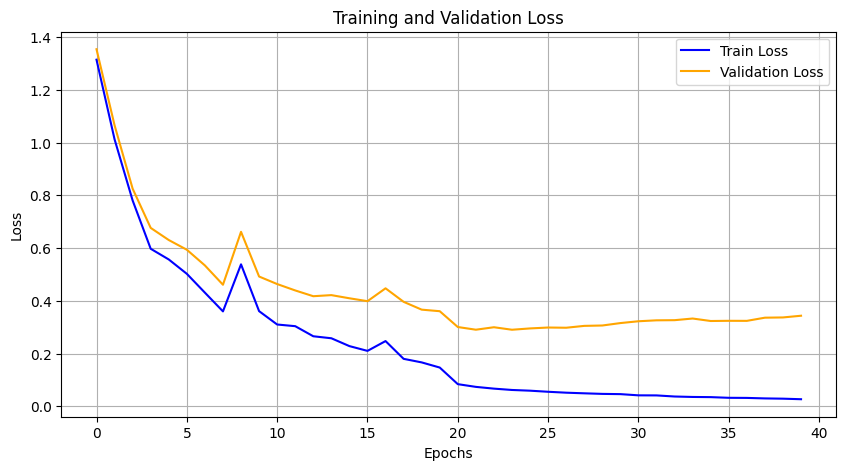

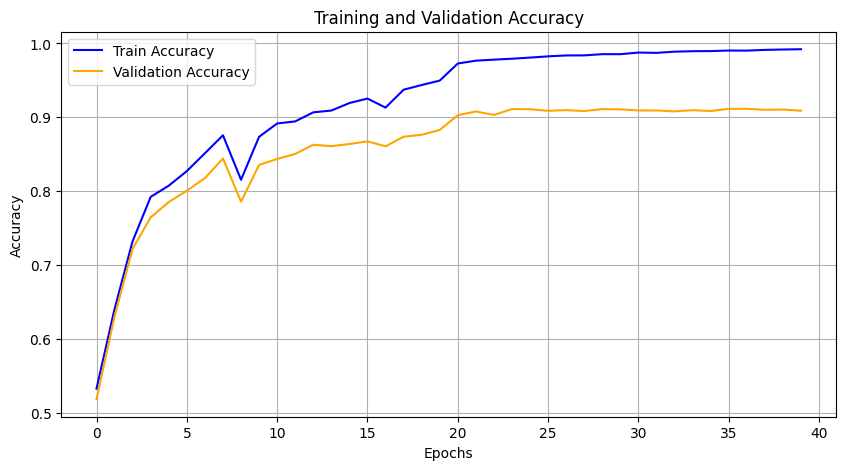

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue')
plt.plot(valid_accs, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [15]:
def get_accuracy_and_loss(net , dataloader):
    net.eval()
    running_loss = 0.0
    correct = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
    return correct / total, running_loss / len(dataloader)

In [16]:
test_accuracy, test_loss = get_accuracy_and_loss(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}   Test Loss: {test_loss:.4f}')

Test Accuracy: 0.92   Test Loss: 0.3568


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

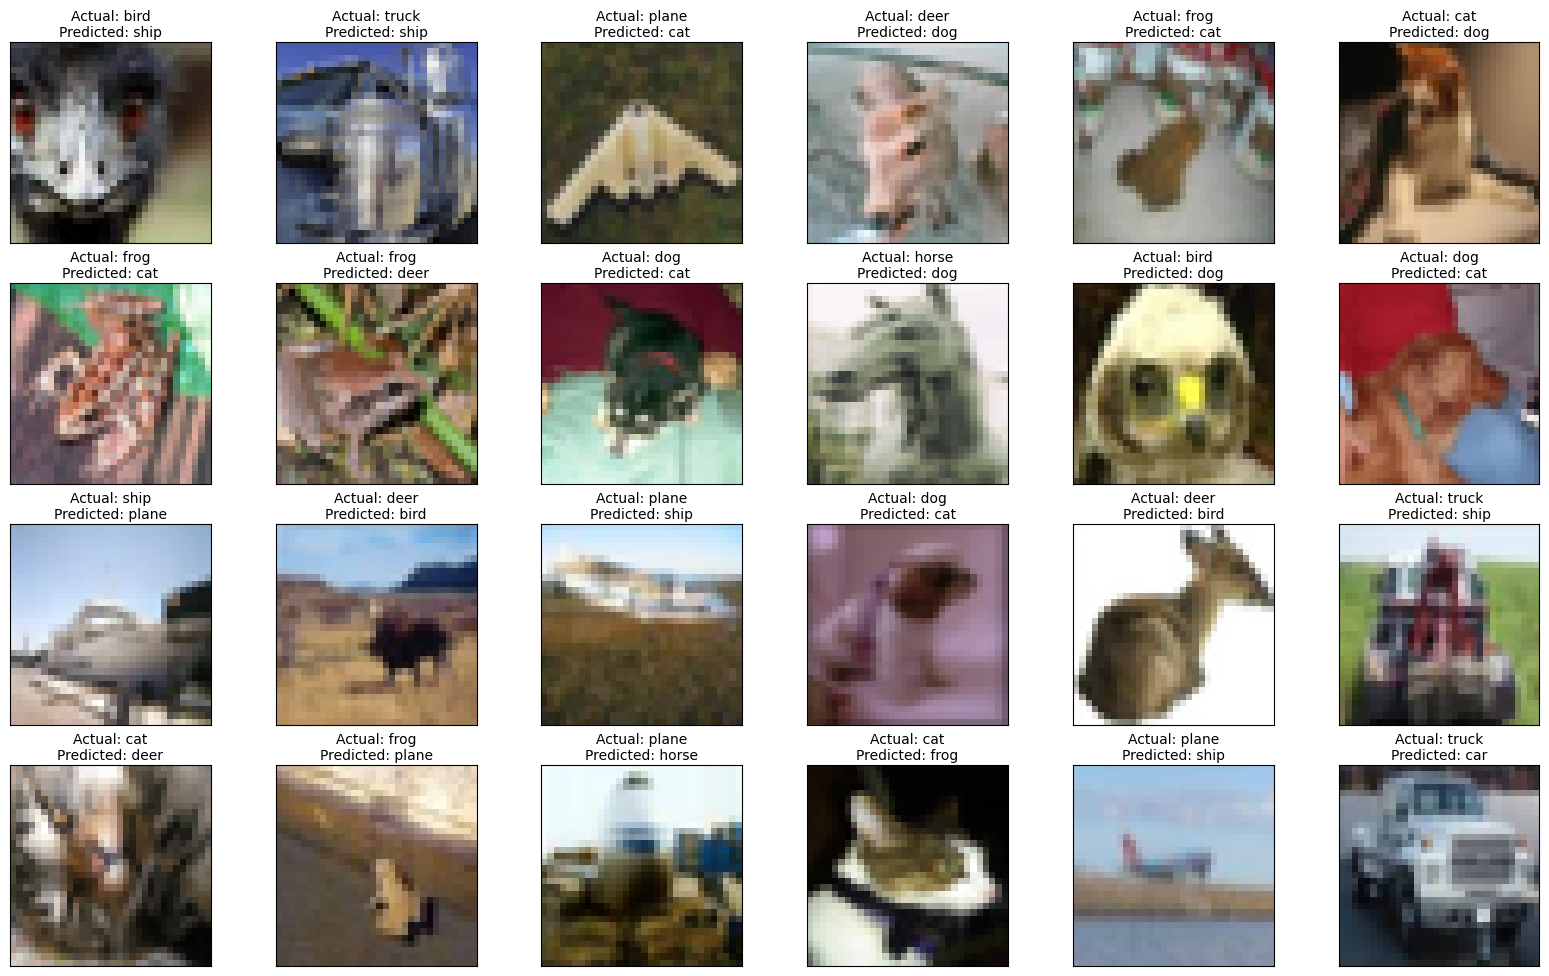

In [17]:
wrongs = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for predict, label, inp in zip(predicted, labels, inputs):
            if predict != label:
                wrongs.append((inp, label, predict))

        if len(wrongs) >= 24:
            break

figs, axs = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)

for i in range(4):
    for j in range(6):
        img, label, predict = wrongs[i * 6 + j]
        img_np = norminv(img.cpu()).numpy()
        img_np = img_np.transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        axs[i, j].imshow(img_np)
        title = f'Actual: {classes[label]}\nPredicted: {classes[predict]}'
        axs[i, j].set_title(title, fontsize=10, pad=4)  # Adjust title font size and padding
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [18]:
loader = torch.utils.data.DataLoader(ConcatDataset([test_dataset, train_dataset]), batch_size=200, shuffle=False)

outputs = []
labels = []
inputs = []

with torch.no_grad():
    for data in loader:
        batch_inputs, batch_labels = data[0].to(device), data[1].to(device)

        # Forward pass through the model
        features = model.conv1(batch_inputs)
        features = model.bn1(features)
        features = F.relu(features)
        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)
        features = model.layer4(features)
        features = model.avg_pool(features)
        features = features.view(features.size(0), -1)

        outputs.append(features)
        labels.append(batch_labels)
        inputs.append(batch_inputs)

outputs = torch.cat(outputs)
labels = torch.cat(labels)
inputs = torch.cat(inputs)

print("Feature space shape:", outputs.shape)


Feature space shape: torch.Size([50000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

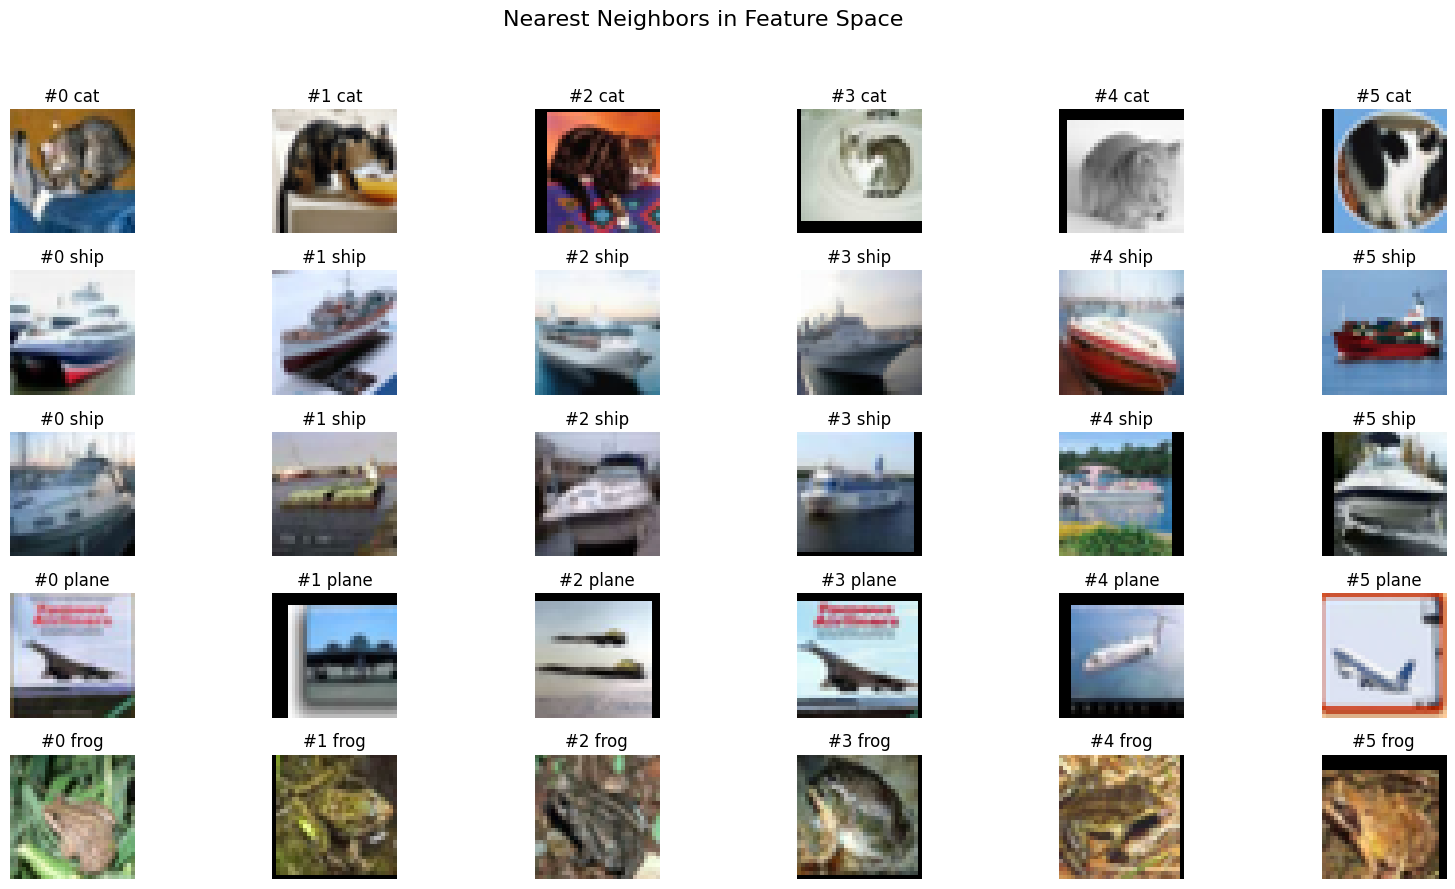

In [19]:
num_samples = 5

fig, axs = plt.subplots(num_samples, 6, figsize=(20, 10))
fig.suptitle('Nearest Neighbors in Feature Space', fontsize=16)

axs[0, 0].set_title('Test Image')
for i in range(1, 6):
    axs[0, i].set_title(f'#{i} Closest in Train')

with torch.no_grad():
    _, predicted = torch.max(model.fc(outputs), 1)

    for idx, (out, label, pred) in enumerate(zip(outputs, labels, predicted)):
        if num_samples == 0:
            break
        if pred == label:
            _, similar_indices = torch.topk(torch.linalg.norm(outputs - out, dim=1), k=6, largest=False)
            for i, sim_idx in enumerate(similar_indices):
                sim_img = norminv(inputs[sim_idx].cpu()).numpy()
                sim_img = (sim_img - sim_img.min()) / (sim_img.max() - sim_img.min())
                axs[5 - num_samples, i].imshow(sim_img.transpose(1, 2, 0))
                axs[5 - num_samples, i].axis('off')
                axs[5 - num_samples, i].set_title(f'#{i} {classes[labels[sim_idx].item()]}')
            num_samples -= 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


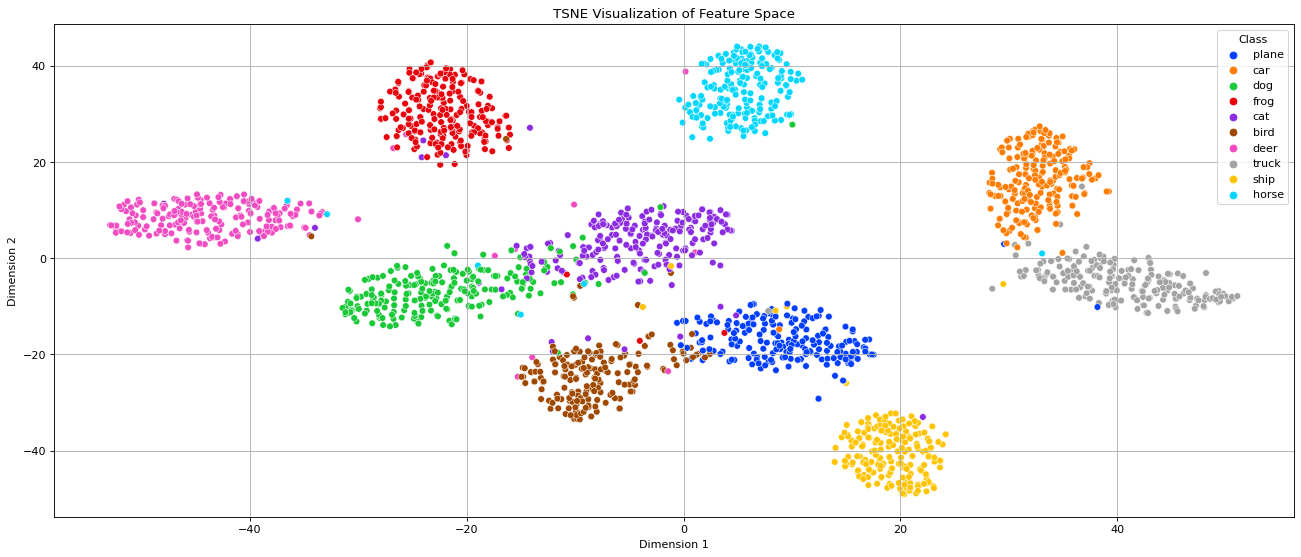

In [20]:
indices = torch.randperm(outputs.size(0))[:2000]

X = outputs[indices].cpu().numpy()
y = labels[indices].cpu().numpy()

# Reduce dimension
X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)

data = pd.DataFrame({
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
    'label': [classes[t] for t in y],
})

# Plot
plt.figure(figsize=(20, 8), dpi=80)
cmap = sns.color_palette("bright", 10).as_hex()
sns.scatterplot(data=data, x='x', y='y', hue='label', palette=cmap)
plt.title('TSNE Visualization of Feature Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.legend(title='Class')
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [21]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [23]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`.
    This class is a dataset for the CIFAR10 data in PyTorch. It outputs the black-and-white image of the original CIFAR10 image as the data
    and the original RGB image as the target. This class is just a wrapper for the torchvision.datasets.CIFAR10 class.
    """

    def __init__(self, train=True, root='./data', download=True, transform= transforms.Grayscale()):

        self.cifar10_dataset = CIFAR10(root=root, train=train, download=download, transform=transforms.Compose([transforms.ToTensor()]))

        self.transform = transform

    def __len__(self):

        return len(self.cifar10_dataset)

    def __getitem__(self, index):

        original_img, label = self.cifar10_dataset[index]
        bw_img = self.transform(original_img)


        return bw_img, original_img



## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [24]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [25]:
trainset = BlackAndWhiteCIFAR10(train=True)
validset = BlackAndWhiteCIFAR10(train=False)

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=128)
validloader = torch.utils.data.DataLoader(validset, shuffle=False, num_workers=2, batch_size=256)


Files already downloaded and verified
Files already downloaded and verified


In [26]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

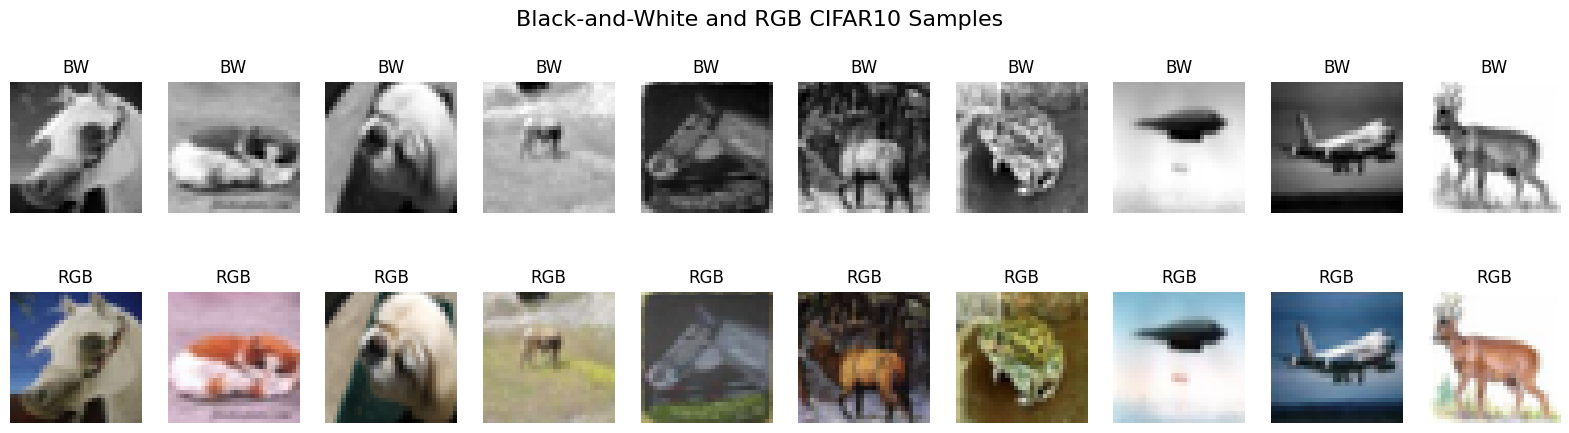

In [27]:
def visualize_dataset(dataset, num_samples=10):
    dataset.cifar10_dataset.train = False

    fig, axes = plt.subplots(2, num_samples, figsize=(2*num_samples, 5))
    fig.suptitle('Black-and-White and RGB CIFAR10 Samples', fontsize=16)

    for i in range(num_samples):
        index = np.random.randint(len(dataset))
        bw_img, rgb_img = dataset[index]

        axes[0, i].imshow(np.squeeze(bw_img.numpy()), cmap='gray')
        axes[0, i].set_title('BW')

        axes[1, i].imshow(np.transpose(rgb_img, (1, 2, 0)))
        axes[1, i].set_title('RGB')

        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.show()

visualize_dataset(trainset)


## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [28]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampleBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, (diffX + 1) // 2, diffY // 2, (diffY + 1) // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(UNet, self).__init__()

        self.inc = DoubleConvBlock(in_channels, 64)
        self.down1 = self.down_block(64, 128)
        self.down2 = self.down_block(128, 256)
        self.down3 = self.down_block(256, 512)
        self.down4 = self.down_block(512, 512)
        self.up1 = UpSampleBlock(1024, 256)
        self.up2 = UpSampleBlock(512, 128)
        self.up3 = UpSampleBlock(256, 64)
        self.up4 = UpSampleBlock(128, 64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [29]:
net = UNet(1,3).to(device)

summary(net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
   DoubleConvBlock-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        LeakyReLU-14          [-1, 128,

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [31]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / len(dataloader)})
    scheduler.step()
    
    return running_loss / len(dataloader)


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc="Validation" if not test_mode else "Testing", leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / len(dataloader)})
    return running_loss / len(dataloader)


In [32]:
epochs = 40
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print(f'[Epoch {epoch + 1:2d}] [{datetime.now().strftime("%H:%M:%S")}]', end=' ' * 3)
    print(f'LR: {scheduler.get_last_lr()[0]:.6f}', end=' ' * 3)
    train_loss = train_epoch(net, criterion, optimizer, scheduler, trainloader)
    valid_loss = eval_epoch(net, criterion, validloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Train Loss: {train_loss:.4f}', end=' ' * 3)
    print(f'Validation Loss: {valid_loss:.4f}')

print('Training complete.')


[Epoch  1] [20:34:08]   LR: 0.000200   

Train Loss: 0.0212   Validation Loss: 0.0062
[Epoch  2] [20:34:49]   LR: 0.000200   

Train Loss: 0.0061   Validation Loss: 0.0072
[Epoch  3] [20:35:31]   LR: 0.000200   

Train Loss: 0.0060   Validation Loss: 0.0063
[Epoch  4] [20:36:12]   LR: 0.000200   

Train Loss: 0.0057   Validation Loss: 0.0055
[Epoch  5] [20:36:53]   LR: 0.000200   

Train Loss: 0.0055   Validation Loss: 0.0060
[Epoch  6] [20:37:34]   LR: 0.000200   

Train Loss: 0.0054   Validation Loss: 0.0054
[Epoch  7] [20:38:15]   LR: 0.000200   

Train Loss: 0.0053   Validation Loss: 0.0054
[Epoch  8] [20:38:57]   LR: 0.000200   

Train Loss: 0.0052   Validation Loss: 0.0055
[Epoch  9] [20:39:38]   LR: 0.000200   

Train Loss: 0.0054   Validation Loss: 0.0050
[Epoch 10] [20:40:19]   LR: 0.000200   

Train Loss: 0.0053   Validation Loss: 0.0050
[Epoch 11] [20:41:00]   LR: 0.000200   

Train Loss: 0.0052   Validation Loss: 0.0050
[Epoch 12] [20:41:41]   LR: 0.000200   

Train Loss: 0.0051   Validation Loss: 0.0055
[Epoch 13] [20:42:22]   LR: 0.000200   

Train Loss: 0.0050   Validation Loss: 0.0050
[Epoch 14] [20:43:03]   LR: 0.000200   

Train Loss: 0.0049   Validation Loss: 0.0051
[Epoch 15] [20:43:45]   LR: 0.000200   

Train Loss: 0.0048   Validation Loss: 0.0049
[Epoch 16] [20:44:26]   LR: 0.000200   

Train Loss: 0.0047   Validation Loss: 0.0050
[Epoch 17] [20:45:07]   LR: 0.000200   

Train Loss: 0.0046   Validation Loss: 0.0048
[Epoch 18] [20:45:48]   LR: 0.000200   

Train Loss: 0.0044   Validation Loss: 0.0052
[Epoch 19] [20:46:29]   LR: 0.000200   

Train Loss: 0.0042   Validation Loss: 0.0050
[Epoch 20] [20:47:11]   LR: 0.000200   

Train Loss: 0.0041   Validation Loss: 0.0049
[Epoch 21] [20:47:52]   LR: 0.000200   

Train Loss: 0.0038   Validation Loss: 0.0051
[Epoch 22] [20:48:33]   LR: 0.000200   

Train Loss: 0.0036   Validation Loss: 0.0053
[Epoch 23] [20:49:14]   LR: 0.000200   

Train Loss: 0.0034   Validation Loss: 0.0051
[Epoch 24] [20:49:55]   LR: 0.000200   

Train Loss: 0.0033   Validation Loss: 0.0050
[Epoch 25] [20:50:37]   LR: 0.000200   

Train Loss: 0.0031   Validation Loss: 0.0051
[Epoch 26] [20:51:18]   LR: 0.000200   

Train Loss: 0.0030   Validation Loss: 0.0051
[Epoch 27] [20:51:59]   LR: 0.000200   

Train Loss: 0.0029   Validation Loss: 0.0056
[Epoch 28] [20:52:40]   LR: 0.000200   

Train Loss: 0.0028   Validation Loss: 0.0053
[Epoch 29] [20:53:21]   LR: 0.000200   

Train Loss: 0.0027   Validation Loss: 0.0050
[Epoch 30] [20:54:02]   LR: 0.000200   

Train Loss: 0.0026   Validation Loss: 0.0051
[Epoch 31] [20:54:44]   LR: 0.000020   

Train Loss: 0.0022   Validation Loss: 0.0048
[Epoch 32] [20:55:25]   LR: 0.000020   

Train Loss: 0.0021   Validation Loss: 0.0049
[Epoch 33] [20:56:06]   LR: 0.000020   

Train Loss: 0.0021   Validation Loss: 0.0049
[Epoch 34] [20:56:47]   LR: 0.000020   

Train Loss: 0.0020   Validation Loss: 0.0049
[Epoch 35] [20:57:29]   LR: 0.000020   

Train Loss: 0.0020   Validation Loss: 0.0049
[Epoch 36] [20:58:10]   LR: 0.000020   

Train Loss: 0.0020   Validation Loss: 0.0049
[Epoch 37] [20:58:51]   LR: 0.000020   

Train Loss: 0.0019   Validation Loss: 0.0049
[Epoch 38] [20:59:33]   LR: 0.000020   

Train Loss: 0.0019   Validation Loss: 0.0049
[Epoch 39] [21:00:14]   LR: 0.000020   

Train Loss: 0.0019   Validation Loss: 0.0049
[Epoch 40] [21:00:55]   LR: 0.000020   

Train Loss: 0.0018   Validation Loss: 0.0049
Training complete.


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

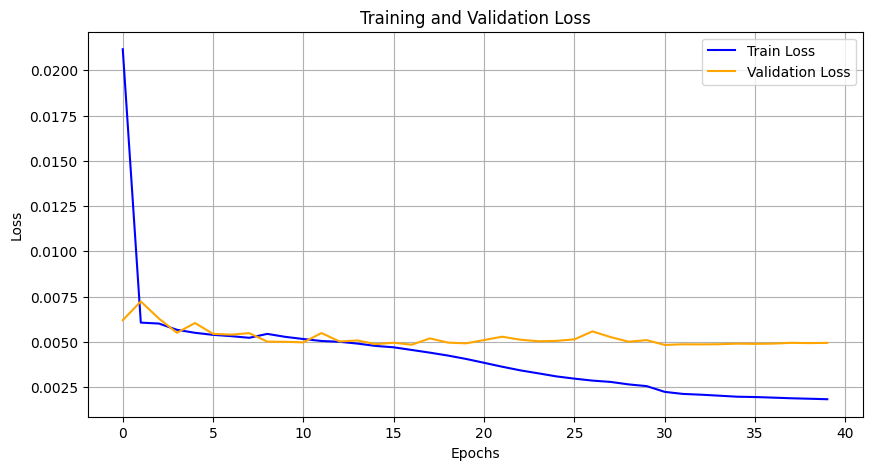

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



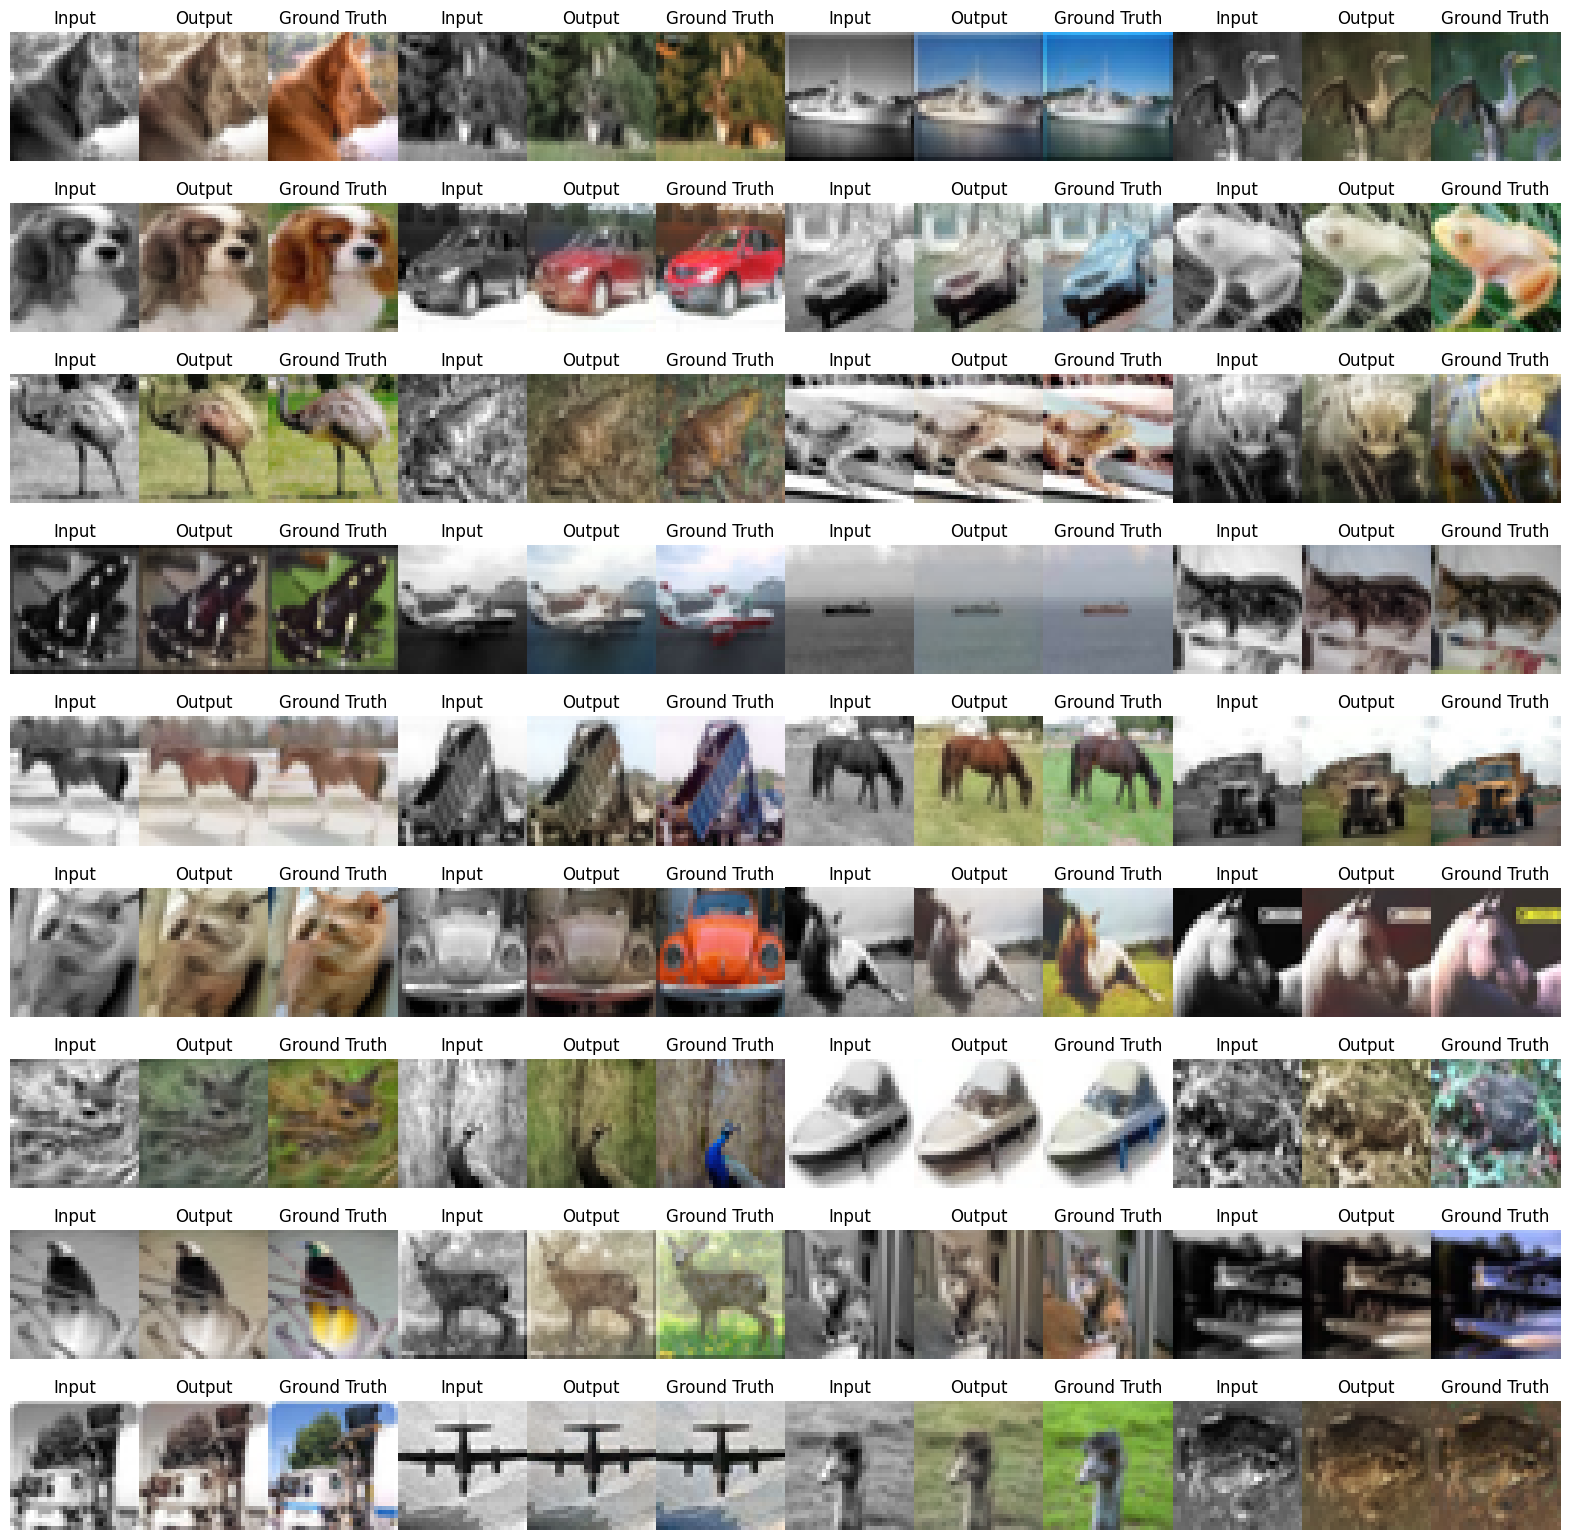

In [34]:
import matplotlib.pyplot as plt
import random

total_samples = len(validloader.dataset)
random_indices = random.sample(range(total_samples), 36)
samples = [validloader.dataset[i] for i in random_indices]

bw_images = [sample[0] for sample in samples]
rgb_images = [sample[1] for sample in samples]

bw_inputs = torch.stack(bw_images)
rgb_labels = torch.stack(rgb_images)

with torch.no_grad():
    outputs = net(bw_inputs.to(device))

plt.figure(figsize=(20, 20))
for i in range(36):
    bw = bw_inputs[i]
    rgb = rgb_labels[i]
    predict = outputs[i]
    x, y = (i // 12), 3 * (i % 12)
    plt.subplot(9, 12, i*3 + 1)
    plt.imshow(bw.cpu().numpy()[0], cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(9, 12, i*3 + 2)
    plt.imshow(predict.cpu().numpy().transpose(1, 2, 0))
    plt.title("Output")
    plt.axis('off')

    plt.subplot(9, 12, i*3 + 3)
    plt.imshow(rgb.cpu().numpy().transpose(1, 2, 0))
    plt.title("Ground Truth")
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
